# Project 2: Ames Housing Saleprice Prediction
---

Project notebook organisation:<br>
[1 - Data Cleaning](./1_data-cleaning.ipynb) <br>
[2 - Exploratory Data Analysis and Feature Engineering](./2_eda.ipynb)<br>
**[3 - Modelling and insights]** (current notebook)<br>

<br>
<br>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import sklearn.metrics as metrics
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_val_score, train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, median_absolute_error
from sklearn.dummy import DummyRegressor

sns.set_style()

pd.set_option('display.max_columns', None)

%matplotlib inline

## Introduction

This third notebook in the project will cover the modelling portion of the project and the identification of a suitable production model that is used for generating the required Kaggle submissions. 

## Contents of this workbook
---

1. [Load relevant datasets](#Load-relevant-datasets)
2. [One-hot encoding](#One-hot-encoding)
1. [Splitting data](#Splitting-data)
1. [Scaling data](#Scaling-data)
1. [Hyperparameter tuning](#Hyperparameter-tuning)
1. [Cross validation](#Cross-validation)
1. [Model evaluation](#Model-evaluation)
1. [Insights from model evaluation](#Insights-from-model-evaluation)
1. [Plotting residuals](#Plotting-residuals)
1. [Production model](#Production-model)
  1. [First Kaggle submission](#First-Kaggle-submission)
  1. [Second Kaggle submission](#Second-Kaggle-submission)
1. [Conclusions and recommendations](#Conclusions-and-recommendations)

## Load relevant datasets

In [2]:
#Load relevant datasets

test = pd.read_csv('./datasets/test_preproc.csv')
train = pd.read_csv('./datasets/train_preproc.csv')

train.drop(['Unnamed: 0'], axis = 1, inplace = True)
test.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [3]:
train.shape

(2048, 48)

In [4]:
test.shape

(879, 47)

In [5]:
train.head()

,id,ms_zoning,lot_frontage,lot_area,lot_shape,land_contour,lot_config,land_slope,neighborhood,condition_1,bldg_type,house_style,overall_qual,year_built,roof_style,mas_vnr_type,mas_vnr_area,exter_qual,foundation,bsmt_qual,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmt_unf_sf,total_bsmt_sf,heating_qc,1st_flr_sf,2nd_flr_sf,gr_liv_area,bsmt_full_bath,full_bath,half_bath,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_finish,garage_area,garage_cond,wood_deck_sf,saleprice,exterior,porch,remodelled,pool
0,109.0,rl,70.0,13517.0,1,lvl,culdsac,gtl,sawyer,rrae,1fam,2story,6.0,1976.0,gable,brkface,289.0,4,cblock,3,1,glq,533.0,unf,192.0,725.0,5,725.0,754.0,1479.0,0.0,2.0,1.0,4,6.0,typ,0.0,0,attchd,rfn,475.0,ta,0.0,130500.0,wood,1,1.0,0
1,544.0,rl,43.0,11492.0,1,lvl,culdsac,gtl,sawyerw,norm,1fam,2story,7.0,1996.0,gable,brkface,132.0,4,pconc,4,1,glq,637.0,unf,276.0,913.0,5,913.0,1209.0,2122.0,1.0,2.0,1.0,4,8.0,typ,1.0,3,attchd,rfn,559.0,ta,0.0,220000.0,vinyl,1,1.0,0
2,153.0,rl,68.0,7922.0,0,lvl,inside,gtl,names,norm,1fam,1story,5.0,1953.0,gable,none,0.0,3,cblock,3,1,glq,731.0,unf,326.0,1057.0,3,1057.0,0.0,1057.0,1.0,1.0,0.0,4,5.0,typ,0.0,0,detchd,unf,246.0,ta,0.0,109000.0,vinyl,1,1.0,0
3,318.0,rl,73.0,9802.0,0,lvl,inside,gtl,timber,norm,1fam,2story,5.0,2006.0,gable,none,0.0,3,pconc,4,1,unf,0.0,unf,384.0,384.0,4,744.0,700.0,1444.0,0.0,2.0,1.0,3,7.0,typ,0.0,0,builtin,fin,400.0,ta,100.0,174000.0,vinyl,0,1.0,0
4,255.0,rl,82.0,14235.0,1,lvl,inside,gtl,sawyerw,norm,1fam,1.5fin,6.0,1900.0,gable,none,0.0,3,pconc,2,1,unf,0.0,unf,676.0,676.0,3,831.0,614.0,1445.0,0.0,2.0,0.0,3,6.0,typ,0.0,0,detchd,unf,484.0,ta,0.0,138500.0,wood,1,1.0,0


## One-hot encoding

In [6]:
train_dummies = pd.get_dummies(train, drop_first = True)

In [7]:
train_dummies.shape

(2048, 143)

In [8]:
test_dummies = pd.get_dummies(test, drop_first = True)

In [9]:
test_dummies.shape

(879, 137)

In [10]:
train_dummies.isnull().sum()

id                0
lot_frontage      0
lot_area          0
lot_shape         0
overall_qual      0
                 ..
exterior_brick    0
exterior_metal    0
exterior_stone    0
exterior_vinyl    0
exterior_wood     0
Length: 143, dtype: int64

In [11]:
df_nullcount = pd.DataFrame(train_dummies.isnull().sum(), columns = ['nulls'])
df_nullcount = df_nullcount[df_nullcount['nulls'] != 0]
df_nullcount

,nulls


In [12]:
train_dummies.head()

,id,lot_frontage,lot_area,lot_shape,overall_qual,year_built,mas_vnr_area,exter_qual,bsmt_qual,bsmt_exposure,bsmtfin_sf_1,bsmt_unf_sf,total_bsmt_sf,heating_qc,1st_flr_sf,2nd_flr_sf,gr_liv_area,bsmt_full_bath,full_bath,half_bath,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_area,wood_deck_sf,saleprice,porch,remodelled,pool,ms_zoning_c (all),ms_zoning_fv,ms_zoning_i (all),ms_zoning_rh,ms_zoning_rl,ms_zoning_rm,land_contour_hls,land_contour_low,land_contour_lvl,lot_config_culdsac,lot_config_fr2,lot_config_fr3,lot_config_inside,land_slope_mod,land_slope_sev,neighborhood_blueste,neighborhood_brdale,neighborhood_brkside,neighborhood_clearcr,neighborhood_collgcr,neighborhood_crawfor,neighborhood_edwards,neighborhood_gilbert,neighborhood_greens,neighborhood_grnhill,neighborhood_idotrr,neighborhood_landmrk,neighborhood_meadowv,neighborhood_mitchel,neighborhood_names,neighborhood_noridge,neighborhood_npkvill,neighborhood_nridght,neighborhood_nwames,neighborhood_oldtown,neighborhood_sawyer,neighborhood_sawyerw,neighborhood_somerst,neighborhood_stonebr,neighborhood_swisu,neighborhood_timber,neighborhood_veenker,condition_1_feedr,condition_1_norm,condition_1_posa,condition_1_posn,condition_1_rrae,condition_1_rran,condition_1_rrne,condition_1_rrnn,bldg_type_2fmcon,bldg_type_duplex,bldg_type_twnhs,bldg_type_twnhse,house_style_1.5unf,house_style_1story,house_style_2.5fin,house_style_2.5unf,house_style_2story,house_style_sfoyer,house_style_slvl,roof_style_gable,roof_style_gambrel,roof_style_hip,roof_style_mansard,roof_style_shed,mas_vnr_type_brkface,mas_vnr_type_none,mas_vnr_type_stone,foundation_cblock,foundation_pconc,foundation_slab,foundation_stone,foundation_wood,bsmtfin_type_1_blq,bsmtfin_type_1_glq,bsmtfin_type_1_lwq,bsmtfin_type_1_none,bsmtfin_type_1_rec,bsmtfin_type_1_unf,bsmtfin_type_2_blq,bsmtfin_type_2_glq,bsmtfin_type_2_lwq,bsmtfin_type_2_none,bsmtfin_type_2_rec,bsmtfin_type_2_unf,functional_maj2,functional_min1,functional_min2,functional_mod,functional_sal,functional_sev,functional_typ,garage_type_attchd,garage_type_basment,garage_type_builtin,garage_type_carport,garage_type_detchd,garage_type_none,garage_finish_none,garage_finish_rfn,garage_finish_unf,garage_cond_fa,garage_cond_gd,garage_cond_none,garage_cond_po,garage_cond_ta,exterior_aggregate,exterior_brick,exterior_metal,exterior_stone,exterior_vinyl,exterior_wood
0,109.0,70.0,13517.0,1,6.0,1976.0,289.0,4,3,1,533.0,192.0,725.0,5,725.0,754.0,1479.0,0.0,2.0,1.0,4,6.0,0.0,0,475.0,0.0,130500.0,1,1.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,544.0,43.0,11492.0,1,7.0,1996.0,132.0,4,4,1,637.0,276.0,913.0,5,913.0,1209.0,2122.0,1.0,2.0,1.0,4,8.0,1.0,3,559.0,0.0,220000.0,1,1.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,153.0,68.0,7922.0,0,5.0,1953.0,0.0,3,3,1,731.0,326.0,1057.0,3,1057.0,0.0,1057.0,1.0,1.0,0.0,4,5.0,0.0,0,246.0,0.0,109000.0,1,1.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,318.0,73.0,9802.0,0,5.0,2006.0,0.0,3,4,1,0.0,384.0,384.0,4,744.0,700.0,1444.0,0.0,2.0,1.0,3,7.0,0.0,0,400.0,100.0,174000.0,0,1.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,255.0,82.0,14235.0,1,6.0,1900.0,0.0,3,2,1,0.0,676.0,676.0,3,831.0,614.0,1445.0,0.0,2.0,0.0,3,6.0,0.0,0,484.0,0.0,138500.0,1,1.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

224 features are now present after one-hot encoding

## Splitting Data

In [13]:
# Define X and y.
X = train_dummies.drop(train_dummies[['saleprice']], axis = 1) 
y = train_dummies[['saleprice']]



In [14]:
X.head()

,id,lot_frontage,lot_area,lot_shape,overall_qual,year_built,mas_vnr_area,exter_qual,bsmt_qual,bsmt_exposure,bsmtfin_sf_1,bsmt_unf_sf,total_bsmt_sf,heating_qc,1st_flr_sf,2nd_flr_sf,gr_liv_area,bsmt_full_bath,full_bath,half_bath,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_area,wood_deck_sf,porch,remodelled,pool,ms_zoning_c (all),ms_zoning_fv,ms_zoning_i (all),ms_zoning_rh,ms_zoning_rl,ms_zoning_rm,land_contour_hls,land_contour_low,land_contour_lvl,lot_config_culdsac,lot_config_fr2,lot_config_fr3,lot_config_inside,land_slope_mod,land_slope_sev,neighborhood_blueste,neighborhood_brdale,neighborhood_brkside,neighborhood_clearcr,neighborhood_collgcr,neighborhood_crawfor,neighborhood_edwards,neighborhood_gilbert,neighborhood_greens,neighborhood_grnhill,neighborhood_idotrr,neighborhood_landmrk,neighborhood_meadowv,neighborhood_mitchel,neighborhood_names,neighborhood_noridge,neighborhood_npkvill,neighborhood_nridght,neighborhood_nwames,neighborhood_oldtown,neighborhood_sawyer,neighborhood_sawyerw,neighborhood_somerst,neighborhood_stonebr,neighborhood_swisu,neighborhood_timber,neighborhood_veenker,condition_1_feedr,condition_1_norm,condition_1_posa,condition_1_posn,condition_1_rrae,condition_1_rran,condition_1_rrne,condition_1_rrnn,bldg_type_2fmcon,bldg_type_duplex,bldg_type_twnhs,bldg_type_twnhse,house_style_1.5unf,house_style_1story,house_style_2.5fin,house_style_2.5unf,house_style_2story,house_style_sfoyer,house_style_slvl,roof_style_gable,roof_style_gambrel,roof_style_hip,roof_style_mansard,roof_style_shed,mas_vnr_type_brkface,mas_vnr_type_none,mas_vnr_type_stone,foundation_cblock,foundation_pconc,foundation_slab,foundation_stone,foundation_wood,bsmtfin_type_1_blq,bsmtfin_type_1_glq,bsmtfin_type_1_lwq,bsmtfin_type_1_none,bsmtfin_type_1_rec,bsmtfin_type_1_unf,bsmtfin_type_2_blq,bsmtfin_type_2_glq,bsmtfin_type_2_lwq,bsmtfin_type_2_none,bsmtfin_type_2_rec,bsmtfin_type_2_unf,functional_maj2,functional_min1,functional_min2,functional_mod,functional_sal,functional_sev,functional_typ,garage_type_attchd,garage_type_basment,garage_type_builtin,garage_type_carport,garage_type_detchd,garage_type_none,garage_finish_none,garage_finish_rfn,garage_finish_unf,garage_cond_fa,garage_cond_gd,garage_cond_none,garage_cond_po,garage_cond_ta,exterior_aggregate,exterior_brick,exterior_metal,exterior_stone,exterior_vinyl,exterior_wood
0,109.0,70.0,13517.0,1,6.0,1976.0,289.0,4,3,1,533.0,192.0,725.0,5,725.0,754.0,1479.0,0.0,2.0,1.0,4,6.0,0.0,0,475.0,0.0,1,1.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,544.0,43.0,11492.0,1,7.0,1996.0,132.0,4,4,1,637.0,276.0,913.0,5,913.0,1209.0,2122.0,1.0,2.0,1.0,4,8.0,1.0,3,559.0,0.0,1,1.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,153.0,68.0,7922.0,0,5.0,1953.0,0.0,3,3,1,731.0,326.0,1057.0,3,1057.0,0.0,1057.0,1.0,1.0,0.0,4,5.0,0.0,0,246.0,0.0,1,1.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,318.0,73.0,9802.0,0,5.0,2006.0,0.0,3,4,1,0.0,384.0,384.0,4,744.0,700.0,1444.0,0.0,2.0,1.0,3,7.0,0.0,0,400.0,100.0,0,1.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,255.0,82.0,14235.0,1,6.0,1900.0,0.0,3,2,1,0.0,676.0,676.0,3,831.0,614.0,1445.0,0.0,2.0,0.0,3,6.0,0.0,0,484.0,0.0,1,1.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

In [15]:
test_dummies.head()

,id,lot_frontage,lot_area,lot_shape,overall_qual,year_built,mas_vnr_area,exter_qual,bsmt_qual,bsmt_exposure,bsmtfin_sf_1,bsmt_unf_sf,total_bsmt_sf,heating_qc,1st_flr_sf,2nd_flr_sf,gr_liv_area,bsmt_full_bath,full_bath,half_bath,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_area,wood_deck_sf,porch,remodelled,pool,ms_zoning_fv,ms_zoning_i (all),ms_zoning_rh,ms_zoning_rl,ms_zoning_rm,land_contour_hls,land_contour_low,land_contour_lvl,lot_config_culdsac,lot_config_fr2,lot_config_fr3,lot_config_inside,land_slope_mod,land_slope_sev,neighborhood_blueste,neighborhood_brdale,neighborhood_brkside,neighborhood_clearcr,neighborhood_collgcr,neighborhood_crawfor,neighborhood_edwards,neighborhood_gilbert,neighborhood_greens,neighborhood_idotrr,neighborhood_meadowv,neighborhood_mitchel,neighborhood_names,neighborhood_noridge,neighborhood_npkvill,neighborhood_nridght,neighborhood_nwames,neighborhood_oldtown,neighborhood_sawyer,neighborhood_sawyerw,neighborhood_somerst,neighborhood_stonebr,neighborhood_swisu,neighborhood_timber,neighborhood_veenker,condition_1_feedr,condition_1_norm,condition_1_posa,condition_1_posn,condition_1_rrae,condition_1_rran,condition_1_rrne,condition_1_rrnn,bldg_type_2fmcon,bldg_type_duplex,bldg_type_twnhs,bldg_type_twnhse,house_style_1.5unf,house_style_1story,house_style_2.5fin,house_style_2.5unf,house_style_2story,house_style_sfoyer,house_style_slvl,roof_style_gable,roof_style_gambrel,roof_style_hip,roof_style_mansard,roof_style_shed,mas_vnr_type_brkface,mas_vnr_type_cblock,mas_vnr_type_none,mas_vnr_type_stone,foundation_cblock,foundation_pconc,foundation_slab,foundation_stone,foundation_wood,bsmtfin_type_1_blq,bsmtfin_type_1_glq,bsmtfin_type_1_lwq,bsmtfin_type_1_none,bsmtfin_type_1_rec,bsmtfin_type_1_unf,bsmtfin_type_2_blq,bsmtfin_type_2_glq,bsmtfin_type_2_lwq,bsmtfin_type_2_none,bsmtfin_type_2_rec,bsmtfin_type_2_unf,functional_maj2,functional_min1,functional_min2,functional_mod,functional_typ,garage_type_attchd,garage_type_basment,garage_type_builtin,garage_type_carport,garage_type_detchd,garage_type_none,garage_finish_none,garage_finish_rfn,garage_finish_unf,garage_cond_fa,garage_cond_gd,garage_cond_none,garage_cond_po,garage_cond_ta,exterior_aggregate,exterior_brick,exterior_metal,exterior_vinyl,exterior_wood
0,2658.0,69.0,9142.0,0,6.0,1910.0,0.0,3,2,1,0.0,1020.0,1020.0,4,908.0,1020.0,1928.0,0.0,2.0,0.0,2,9.0,0.0,0,440.0,0.0,1,1.0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,2718.0,75.0,9662.0,1,5.0,1977.0,0.0,3,4,1,0.0,1967.0,1967.0,3,1967.0,0.0,1967.0,0.0,2.0,0.0,3,10.0,0.0,0,580.0,170.0,0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,2414.0,58.0,17104.0,1,7.0,2006.0,0.0,4,4,3,554.0,100.0,654.0,5,664.0,832.0,1496.0,1.0,2.0,1.0,4,7.0,1.0,4,426.0,100.0,1,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
3,1989.0,60.0,8520.0,0,5.0,1923.0,0.0,4,3,1,0.0,968.0,968.0,3,968.0,0.0,968.0,0.0,1.0,0.0,3,5.0,0.0,0,480.0,0.0,0,1.0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,625.0,74.5,9500.0,1,6.0,1963.0,247.0,3,4,1,609.0,785.0,1394.0,4,1394.0,0.0,1394.0,1.0,1.0,1.0,3,6.0,2.0,4,514.0,0.0,1,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [16]:
# Create training and testing sets. Train:test split is 70:30
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.7)


## Scaling data

In [17]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

## Hyperparameter tuning

### Ridge regression $\alpha$

In [18]:
r_alpha = np.logspace (0,5,200)

# fits multiple alphas
ridgecv = RidgeCV(alphas = r_alpha, cv = 5)
ridgecv = ridgecv.fit(X_train, y_train)

print(f'optimal ridge alpha: {ridgecv.alpha_}')
print(f'optimal ridge R^2: {ridgecv.score(X_train, y_train)}')

optimal ridge alpha: 182.51834943190443
optimal ridge R^2: 0.9127194110654165


### Lasso regression $\alpha$

In [19]:
l_alpha = np.arange(0.001, 0.15, 0.0025)

# Fit to multiple alphas
lassocv = LassoCV(alphas = l_alpha, cv = 5)
lassocv = lassocv.fit(X_train, y_train)

print(f'optimal lasso alpha: {lassocv.alpha_}')
print(f'optimal lasso R^2: {lassocv.score(X_train, y_train)}')

optimal lasso alpha: 0.1485
optimal lasso R^2: 0.9269128168080238


### Elastic net $\alpha$ and $\alpha_2$

In [20]:
enet_alpha = np.arange(0, 1, 0.005)
enet_ratio = [.01, .1, .2, .3, .5, .7, .9, .95, .99, 1]

# Fit to the multiple alphas and rhos
enetcv = ElasticNetCV(alphas = enet_alpha, l1_ratio = enet_ratio, cv = 5)
enetcv = enetcv.fit(X_train, y_train)

print(f'optimal enet alpha: {enetcv.alpha_}')
print(f'optimal enet alpha_2: {enetcv.l1_ratio_}')
print(f'best elastic net R^2: {enetcv.score(X_train, y_train)}')

optimal enet alpha: 0.37
optimal enet alpha_2: 0.01
best elastic net R^2: 0.9099318353884586


## Cross validation

In [21]:
# Instantiate models with previously selected hyperparameters
lin_reg = LinearRegression()
ridge_reg = Ridge(alpha = ridgecv.alpha_)
lasso_reg = Lasso(alpha = lassocv.alpha_)
enet = ElasticNet(alpha = enetcv.alpha_, l1_ratio = enetcv.l1_ratio_)

In [22]:
#This function runs cross-validation across a number of K-values
def cross_validator(model, X_train, y_train):
    for folds in range(5,11):
        print ('------------------------------------\n')
        print ('K:', folds)
        model = model
        
        # Insert RMSE metric
        rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv = folds, scoring = 'neg_mean_squared_error'))
        
        # Perform cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=folds)
        print ("Cross-validated scores:", scores)
        print ("Mean CV R2:", np.mean(scores))
        print ('Std CV R2:', np.std(scores))
        print ('RMSE:', rmse.mean())

        # Make cross-validated predictions
        predictions = cross_val_predict(model, X_train, y_train, cv=folds)

        r2 = metrics.r2_score(y_train, predictions)
        print ("Cross-Predicted R2:", r2)

In [23]:
# Cross-validation for Linear Regression
cross_validator(lin_reg, X_train, y_train)

------------------------------------

K: 5
Cross-validated scores: [-4.01277515e+23 -5.72005351e+22 -6.02888122e+18 -6.08363262e+23
 -4.26434322e+24]
Mean CV R2: -1.066238111858712e+24
Std CV R2: 1.6146024856967602e+24
RMSE: 5.50385760683705e+16
Cross-Predicted R2: -8.699597767393111e+23
------------------------------------

K: 6
Cross-validated scores: [-3.19753775e+22 -3.03945314e+21 -4.81042445e+18 -3.73225156e+23
 -3.83207319e+19 -1.42759856e+25]
Mean CV R2: -2.447378127802242e+24
Std CV R2: 5.291599265765412e+24
RMSE: 5.357150169033539e+16
Cross-Predicted R2: -1.834009661391429e+24
------------------------------------

K: 7
Cross-validated scores: [-8.03908167e+22 -5.49237708e+23 -5.10133419e+21 -1.51321726e+16
 -5.14176856e+21 -3.90910578e+25 -3.75426561e+23]
Mean CV R2: -5.729479432486877e+24
Std CV R2: 1.3621261647864775e+25
RMSE: 8.937635223524829e+16
Cross-Predicted R2: -5.68028343382882e+24
------------------------------------

K: 8
Cross-validated scores: [-1.83735993e+22 -

In [24]:
# Cross Validation for Ridge Regression
cross_validator(ridge_reg, X_train, y_train)

------------------------------------

K: 5
Cross-validated scores: [0.85469279 0.84169794 0.88133796 0.87885434 0.87685731]
Mean CV R2: 0.8666880661980043
Std CV R2: 0.015712694918688958
RMSE: 28718.53727064042
Cross-Predicted R2: 0.8654110560428971
------------------------------------

K: 6
Cross-validated scores: [0.84623415 0.8444755  0.89271411 0.86346755 0.89388289 0.86117792]
Mean CV R2: 0.86699202097537
Std CV R2: 0.019869799524913162
RMSE: 28404.433127472366
Cross-Predicted R2: 0.8688421687740242
------------------------------------

K: 7
Cross-validated scores: [0.84599621 0.88415982 0.84802692 0.87531325 0.8798747  0.8817467
 0.88671657]
Mean CV R2: 0.8716905974900151
Std CV R2: 0.015958253326045013
RMSE: 28081.01223042836
Cross-Predicted R2: 0.8683482973946601
------------------------------------

K: 8
Cross-validated scores: [0.82995527 0.88342543 0.8471776  0.87946712 0.84685961 0.88952256
 0.88449254 0.8798961 ]
Mean CV R2: 0.8675995306912874
Std CV R2: 0.0211328763968237

In [25]:
# Cross Validation for Lasso Regression
cross_validator(lasso_reg, X_train, y_train)

------------------------------------

K: 5
Cross-validated scores: [0.80442866 0.82067128 0.84719003 0.87200605 0.64829549]
Mean CV R2: 0.7985183017754152
Std CV R2: 0.07856458154531377
RMSE: 34437.659378856886
Cross-Predicted R2: 0.8055653058580444
------------------------------------

K: 6
Cross-validated scores: [0.83040277 0.79933408 0.87722434 0.83392458 0.89542066 0.56160758]
Mean CV R2: 0.7996523359063206
Std CV R2: 0.11103645912118626
RMSE: 33425.98491830615
Cross-Predicted R2: 0.8142891249617972
------------------------------------

K: 7
Cross-validated scores: [0.83618673 0.84505057 0.82308731 0.8359433  0.84394357 0.87407947
 0.75310118]
Mean CV R2: 0.8301988751977969
Std CV R2: 0.03463787802303038
RMSE: 31942.36194374838
Cross-Predicted R2: 0.8319476023727708
------------------------------------

K: 8
Cross-validated scores: [0.80973673 0.86338995 0.79434595 0.84821119 0.81138776 0.85529124
 0.84958286 0.84285437]
Mean CV R2: 0.8343500063775833
Std CV R2: 0.0237480323799897

In [26]:
# Cross Validation for Elastic Net Regression
cross_validator(enet, X_train, y_train)

------------------------------------

K: 5
Cross-validated scores: [0.85473547 0.84174054 0.88128261 0.87899578 0.87668529]
Mean CV R2: 0.8666879358506121
Std CV R2: 0.015682273936379415
RMSE: 28718.376274891973
Cross-Predicted R2: 0.8654175884115445
------------------------------------

K: 6
Cross-validated scores: [0.84609328 0.84465811 0.89234757 0.86358203 0.89358411 0.86162894]
Mean CV R2: 0.8669823401810671
Std CV R2: 0.019689226621659707
RMSE: 28409.87418818382
Cross-Predicted R2: 0.8687827087312895
------------------------------------

K: 7
Cross-validated scores: [0.84559354 0.88456422 0.84771088 0.87579733 0.87978436 0.88143807
 0.88685649]
Mean CV R2: 0.8716778423499832
Std CV R2: 0.016165234954693238
RMSE: 28084.43010202862
Cross-Predicted R2: 0.868271034290712
------------------------------------

K: 8
Cross-validated scores: [0.83015584 0.88303994 0.84780891 0.87882244 0.84724153 0.88970989
 0.88410735 0.8799583 ]
Mean CV R2: 0.8676055242378171
Std CV R2: 0.02087648568724

Four different models were tested using cross validation from $k=5$ to $k=10$ on the training data:
1. linear regression
2. ridge regression
3. lasso regression
4. elastic net regression

The **elastic net model** and **ridge regression** models performed the best. 
Regularised regression models outperformed ordinary linear regression, which from its CV performance (extremely small R<sup>2</sup>) appeared to be an very poor fit to this dataset.

This is probably unsurprising, given the large number of features and complex relationship between them and `saleprice`).

## Model evaluation

In [27]:
# THis function returns a series of error metrics
def metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return(f'Mean squared error =  {mse} \n Root mean squared error = {rmse} \n Median absolute error =  {mae} \n Median absolute error = {mae} \n R^2 = {r2}')


# fit a linear regression model to train data
lin_reg = lin_reg.fit(X_train, y_train)
# predict on test data
y_pred = lin_reg.predict(X_test)
# evaluate model performance
print(f'Linear Regression: \n {metrics(y_test, y_pred)}')


# fit a ridge regression model to train data
ridge_reg = ridge_reg.fit(X_train, y_train)
# predict on test data
y_pred = ridge_reg.predict(X_test)
# evaluate model performance
print(f'Ridge Regression: \n {metrics(y_test, y_pred)}')


# fit a lasso regression model to train data
lasso_reg = lasso_reg.fit(X_train, y_train)
# predict on test data
y_pred = lasso_reg.predict(X_test)
# evaluate model performance
print(f'Lasso Regression: \n {metrics(y_test, y_pred)}')


# fit an eleastic net to train data
enet = enet.fit(X_train, y_train)
# predict on test data
y_pred = enet.predict(X_test)
# evaluate model performance
print(f'Elastic net Regression: \n {metrics(y_test, y_pred)}')

Linear Regression: 
 Mean squared error =  2.957587630395437e+30 
 Root mean squared error = 1719763829831130.5 
 Median absolute error =  16092.688301391638 
 Median absolute error = 16092.688301391638 
 R^2 = -4.697618828564612e+20
Ridge Regression: 
 Mean squared error =  1105287293.5930877 
 Root mean squared error = 33245.86130021431 
 Median absolute error =  13665.374466532929 
 Median absolute error = 13665.374466532929 
 R^2 = 0.8244441399471941
Lasso Regression: 
 Mean squared error =  1401252049.3229754 
 Root mean squared error = 37433.301341492384 
 Median absolute error =  15909.320294342346 
 Median absolute error = 15909.320294342346 
 R^2 = 0.7774352332686673
Elastic net Regression: 
 Mean squared error =  1091717154.6257076 
 Root mean squared error = 33041.14336135642 
 Median absolute error =  13450.76060806941 
 Median absolute error = 13450.76060806941 
 R^2 = 0.8265995229243295


### Comparison of best 2 models

In [28]:
def rmse(ytest, ypred):
    return np.sqrt(mean_squared_error(ytest, ypred))


# fit eleastic net model to train data
enet_mod = enet.fit(X_train, y_train)
# predict on test data
y_pred_enet = enet_mod.predict(X_test)
# evaluate model performance
print('enet test R2: ', enet_mod.score(X_test, y_test))
print('enet test RMSE: ', rmse(y_test, y_pred_enet))


# fit a ridge regression model to train data
ridge_reg = ridge_reg.fit(X_train, y_train)
# predict on test data
y_pred_ridge = ridge_reg.predict(X_test)
# evaluate model performance
print('ridge test R2: ', ridge_reg.score(X_test, y_test))
print('enet test RMSE: ', rmse(y_test, y_pred_ridge))


enet test R2:  0.8265995229243295
enet test RMSE:  33041.14336135642
ridge test R2:  0.8244441399471941
enet test RMSE:  33245.86130021431


## Insights from model evaluation

The four different models from above were evaluated on training and test data and their results are summarised in the following table:

| Regressor   | Metric | Score (Training data) [k = 5] | Score (Test Data) |
|-------------|--------|-------------------------------|-------------------|
| Linear      | RMSE   | 1.62                          | 3.24              |
| Linear      | R^2    | -1.00 e+23                    | -1.56 e+23        |
| Lasso       | RMSE   | 49860.73                      | 37591.37          |
| Lasso       | R^2    | 0.45                          | 0.79              |
| Ridge       | RMSE   | 31609.04                      | 34088.88          |
| Ridge       | R^2    | 0.80                          | 0.83              |
| Elastic Net | RMSE   | 34883.53                      | 31814.26          |
| Elastic Net | R^2    | 0.79                          | 0.84              |


For both training and test data, the **elastic net model** and the **ridge regression** model performed the best and had the highest R2 with minimal variation between training and test data, indicating an absence of overfitting. This means that the models are able to explain 86% of the variations of the training data. The RMSE of around 32,000 means that our best linear prediction of the sale price based on all of the attributes is off by around \$ 32,000 on the test set, on average. We find a similar error when predicting prices on the test set, which indicates that our prediction method will generalize to other samples from the same population.

**Linear regression** provided the **baseline score** and had a very low RMSE, indicating a low standard deviation and spread on the data but a low $R^2$. This is very indicative of an overfit model as the model could accurately predict the score on test data but is unable to ratify its y predictions with the test data.

Surprisingly, **lasso regression** performed relatively well on the test data compared with the training data. Although it did not have the best performance of the 4 models, it is evidence of the regularisation mechanism at work as it causes a poorer fit with the training data by imposing a penalty.

It is evident that regularised regression methods have outperformed simple linear regression. Compared to an ordinary linear regression, regularised regressions apply a penalty term which minimises the coefficients, thereby shrinking the coefficients of the least important features to 0 or close to 0. In this case this reduces the bias and increases the variance compared to simple linear regression by reducing the number of coefficients. 

By scaling the features, coefficients in regularised regression models directly represent the importance of the feature in predicting the outcome. This allows the selection of a subset of features to include in the final model - those that have the most effect on saleprice. As a result, all of the regularised regression methods tested performed better than the ordinary linear regression, and have higher R2- meaning that they were able to explain more of the variations in sale price while more accurately predicting the correct sale price. 

However, regularised regression models are slightly worse for interpretation than an ordinary linear model, as there is no longer a direct relationship between features and the predictor due to the scaling that is done to the features.



## Plotting residuals

### Elastic net model

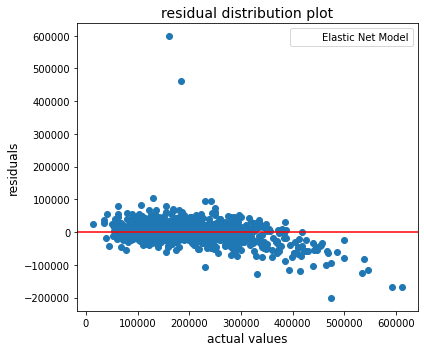

In [29]:
# plot residuals for elastic net model
resid = y_pred_enet - y_test.saleprice

plt.rcParams['figure.figsize'] = (6.0, 5.0)
plt.scatter(y_test.saleprice, resid)
plt.axhline(0, linestyle='-', color='r')
plt.title('residual distribution plot',fontsize=14)
plt.xlabel('actual values',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.plot([], [], ' ', label="Elastic Net Model")
plt.legend()
plt.tight_layout()

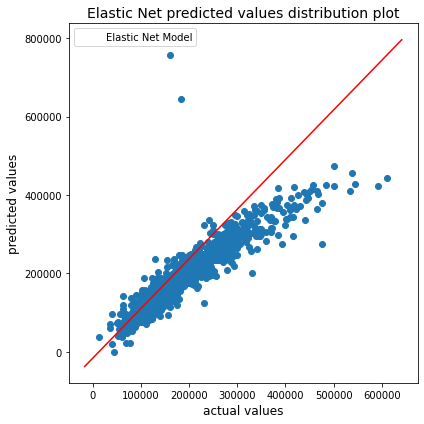

In [30]:
# plot y_pred_enet vs y_true
fig, ax = plt.subplots(figsize=(6.0, 6.0))
ax.scatter(y_test.saleprice, y_pred_enet)
ax.set_title('Elastic Net predicted values distribution plot',fontsize=14)
ax.set_xlabel('actual values',fontsize=12)
ax.set_ylabel('predicted values',fontsize=12)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="r")
plt.plot([], [], ' ', label="Elastic Net Model")
plt.legend()
plt.tight_layout()

In [31]:
y_pred_enet

array([ 77211.60372962, 159568.4769881 , 147572.43370778, ...,
        63909.53430179, 117273.59878209, 295276.39480331])

### Ridge regression model

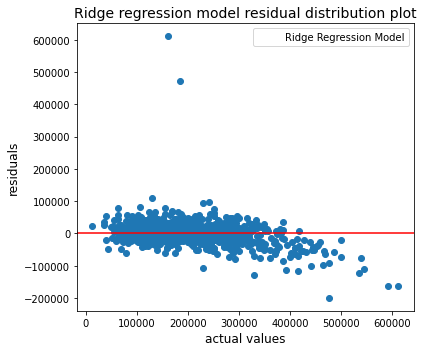

In [32]:
# plot residuals for elastic net model
resid = y_pred_ridge.ravel() - y_test.saleprice

plt.rcParams['figure.figsize'] = (6.0, 5.0)
plt.scatter(y_test.saleprice, resid)
plt.axhline(0, linestyle='-', color='r')
plt.title('Ridge regression model residual distribution plot',fontsize=14)
plt.xlabel('actual values',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.plot([], [], ' ', label="Ridge Regression Model")
plt.legend()
plt.tight_layout()

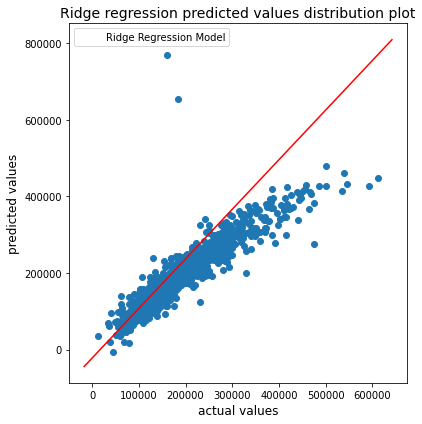

In [33]:
# plot y_pred_ridge vs y_true
fig, ax = plt.subplots(figsize=(6.0, 6.0))
ax.scatter(y_test.saleprice, y_pred_ridge.ravel())
ax.set_title('Ridge regression predicted values distribution plot',fontsize=14)
ax.set_xlabel('actual values',fontsize=12)
ax.set_ylabel('predicted values',fontsize=12)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="r")
plt.plot([], [], ' ', label="Ridge Regression Model")
plt.legend()
plt.tight_layout()

Further examination of the residual plots using the **elastic net** and **ridge regression** model shows a generally equal distribution of variance with the exception of higher values. This generally could indicate that our models are useful for predicting house prices until about $ 400,000. The models are not very good at predicting more expensive houses. 

The plots of predicted y against true y is also generally linear with a 1:1 relationship, except for then higher priced houses.

# Production model

Despite having comparable results, **elastic net regression** functions marginally better than ridge regression and is hence my choice for production model for kaggle submission.

However, the model is not without its limitations. Despite achieving a $R^2$ of 0.83 to 0.84 consistently, plotting its residuals and the true values against its predicted values shows its unreliability at predicting more expensive homes. 

Additionally, a RMSE of around \$ 34,000, while likely to be insignificant with expensive homes is a considerably high spread and can be improved further. It is likely that this high RMSE came about due to its inaccuracy in predicting expensive house prices.

With the model presented, I then use elastic net regression to prepare and submit predictions for th emodel competition. 

Two submissions were made each with different methods of preparation. The submissions presented had to be based on a truncated dataset as dummification of the test set and train set produced shapes of data that were not equivalent to each other (i.e, the training set and the test set would have a different number of features which made prediction impossible).

The first submission was made by dropping columns that would produce different numbers of columns in both datasets. These features are `neighborhood`, `mas_vnr_type`, `functional`, `exterior` and the feature after dummification, `ms_zoning_c (all)`.
Despite these features having been used in the evaluation of the model, the RMSE score of 32285.74838 returned from the Kaggle submission was similar to that of the elastic net evaluation model.

In the second submission, list comprehension was used to selectively remove features after dummification. Doing so represented removing selected entries in dataset. Surprisingly, this approach produced an Kaggle RMSE score of 325139.15805 that was similar, if not slightly worse than the first submission.


### First Kaggle submission

In [ ]:
test_id = pd.read_csv('./datasets/test_preproc.csv')
train = pd.read_csv('./datasets/train_preproc.csv')

In [ ]:
# I have identified these columns from both 'train' and 'test' to be dropped as 
#they cause a mismatched shape after .get_dummies
columns_to_drop =['neighborhood','mas_vnr_type', 'functional', 'exterior']

In [ ]:
# remove unnamed and index columns
test = test_id.iloc[:, 2:]
test.drop(columns_to_drop, axis = 1, inplace = True)

In [ ]:
# remove unnamed and index columns
train = train.iloc[:, 2:]
train.drop(columns_to_drop, axis = 1, inplace = True)

In [ ]:
train_dummies = pd.get_dummies(train, drop_first = True)

In [ ]:
test_dummies = pd.get_dummies(test, drop_first = True)

In [ ]:
# Dropping because this has interfered with the shape of my final model to fit
train_dummies.drop('ms_zoning_c (all)', axis =1, inplace = True)

In [ ]:
# Ensure test_dummies is the correct shape
test_dummies.shape

In [ ]:
# Ensure train_dummies is the correct shape
train_dummies.shape

In [ ]:
# Define X and y.
X = train_dummies.drop(train_dummies[['saleprice']], axis = 1) 
y = train_dummies[['saleprice']]


In [ ]:
# Create training and testing sets. Train:test split is 70:30
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.7)

In [ ]:
# Successful scaling of data
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
test_ss = ss.transform(test_dummies)

In [ ]:
# fit eleastic net model to train data
enet_mod = enet.fit(X_train, y_train)
# predict on test data
y_pred_enet = enet_mod.predict(test_ss)



In [ ]:
export = pd.DataFrame({'SalePrice': y_pred_enet})

In [ ]:
#Ensure the shape of the data is correct
export = pd.DataFrame({'Id': test_id.id.astype('int32'), 'SalePrice': np.abs(y_pred_enet)})
print(export.shape)

In [ ]:
# Export file for Kaggle submission
export.to_csv('./kaggle_submission_20200609.csv', index =False) 

**Scores for first kaggle submission**

Kaggle RMSE score: 32962.60954 



### Second Kaggle submission

In [ ]:
test = pd.read_csv('./datasets/test_preproc.csv')
train = pd.read_csv('./datasets/train_preproc.csv')
test_id = pd.read_csv('./datasets/test_preproc.csv')

train.drop(['Unnamed: 0', 'id'], axis = 1, inplace = True)
test.drop(['Unnamed: 0', 'id'], axis = 1, inplace = True)

In [ ]:
train_dummies = pd.get_dummies(train, drop_first = True)

test_dummies = pd.get_dummies(test, drop_first = True)

In [ ]:
train_set_col = train_dummies.columns
test_set_col = test_dummies.columns

In [ ]:
train_set_not_in_test = [n for n in train_set_col if n not in test_set_col]
train_set_not_in_test.remove("saleprice")

train_set_not_in_test



In [ ]:
test_set_not_in_train = [n for n in test_set_col if n not in train_set_col]
test_set_not_in_train

In [ ]:
train_dummies.drop(['ms_zoning_c (all)',
 'neighborhood_grnhill',
 'neighborhood_landmrk',
 'functional_sal',
 'functional_sev',
 'exterior_stone'],
                  axis =1,
                  inplace =True)

In [ ]:
test_dummies.drop(['mas_vnr_type_cblock'], axis =1, inplace =True)

In [ ]:
# Define X and y.
X = train_dummies.drop(train_dummies[['saleprice']], axis = 1) 
y = train_dummies[['saleprice']]


In [ ]:
# Create training and testing sets. Train:test split is 70:30
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.7)

In [ ]:
# Successful scaling of data
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)
test_ss = ss.transform(test_dummies)

In [ ]:
# fit eleastic net model to train data
enet_mod = enet.fit(X_train, y_train)
# predict on test data
y_pred_enet = enet_mod.predict(test_ss)


In [ ]:
export = pd.DataFrame({'SalePrice': y_pred_enet})

In [ ]:
#Ensure the shape of the data is correct
export = pd.DataFrame({'Id': test_id.id.astype('int32'), 'SalePrice': np.abs(y_pred_enet)})
print(export.shape)

In [ ]:
# Export file for Kaggle submission
export.to_csv('./kaggle_submission_20200610.csv', index =False) 

**Scores for second kaggle submission**

Kaggle RMSE score: 325139.15805


# Conclusions and recommendations

Of the four models, linear regression, lasso regression, ridge regression and elastic net regression, that were used to model and make predictions, the elastic net and ridge regression modesl had the best predictive performance on housing sale price in Ames USA. As regularised regression methods, their ability to lend to reveal which features affect sale price the most made them superior to simple linear regression. 

People looking to buy houses would be able to use the model to see if their prospective purchases was going to be value for money given the listed features in an advertisement. Features such as square feet area, condition, age, and the location of the house are the most important determinant factors of how much a house is priced.
Buyers with limited or specific budgets will be able to find out what features they would be able to afford, e.g. how big a house they can buy in Northridge with a $ 50,000 budget. 
The model also allows buyers to identify the 'expensive' neighbourhoods such as Northridge Heights, Stone Brook, and Northridge. It also indicates areas where houses should be avoided, such as areas gazetted as commercial zones and places close to hte Iowa DOT and Rail Road

Conversely, people looking to sell their house would be able to use the model to get an estimate of how much they would be able to sell their house for, given the features of the house. Furthermore, to receive a higher valuation, house owners should strive to sell their houses sooner rather than later, as the age of the house is the biggest contributing factor to the decrease in value. Unsurprisingly, if the house is severely damaged, its value drops. Sellers looking to increase the value of their home could consider:

- repainting the interior and exterior of the house to improve overall material and finish quality
- renovating the kitchen to improve kitchen quality
- installing a fireplace 
- renovating the garage if it is in bad condition

However, as the model was developed using data on houses sold between 2006 - 2010 in Ames, USA, it may have limited applicabilities. Firstly, it captures only a small time frame of four years which is not enough to capture any annual patterns in sale price that could arise as a result of external factors, such as policy changes and the current economy. It is also unknown whether or not the sale prices had been adjusted for inflation within those years, which would have been a source of variation in saleprice otherwise. 
It would also be inaccurate to generalise it to 2020 as house prices may have changed due to one or more of these factors or even with Covid-19. 

There may also be other factors affecting house price, since the model only accounted for 83-84 \% of the variation in sale price. The remaining 16-17\% could be due to the fact that the model is apparently not very accurate when it comes to larger and more expensive houses exceeding 400,000 in price. This could possibly explained by the RMSE of around 32,000 which means that our best linear prediction of the sale price based on all of the attributes are off by around $ 32,000 on the test set. The first Kaggle submission appears to confirm the RMSE with a score of 32962.60954. 

It must also be noted that the model is specific to Ames and may not be as accurate when applied to data from another city or country. Variations in cultures mean people in different countries look for different things in a house, which would in turn affect sale price. For example, having a fireplace in a house in Singapore (or anywhere in the tropics) is unlikely to bring the value of the house up, as few people in these places want a fireplace in their house. To make the model more universal, data should be extracted from a sample of the entire world or even just a region so that distributions form a bell curve. This would allow us to generalise our findings to different regions other than Ames. 

There are many steps to improve the applicability and ability of the model. Apart from increasing the population from just Ames, Iowas to perhaps the state, the USA or even the entire world, we can consider adding more data from a wider time frame, from different locations, and on more universal features. 

To improve the accuacy of the model, we could also improve the feature engineering step of modelling as shown in the second workbook. Greater care can be taken in further reducing the number of features that have been fed into the modelby amalgamating information, such as combining 2 features such as `fireplace` and `fireplace_qu` into a single feature that just indicates the presence of a fireplace. As proven in the two Kaggle submissions, it is better to drop features altogether as opposed to dropping single values, leaving 'data holes' in the dataset.  

House prices are by their very nature difficult to predict as it is also affected by buyers' psychology, the economic climate, and other factors not included in the present dataset. It is unlikely we will be able to construct a perfect model and the aim of this model is therefore only present as a guideline to inform buyers ans sellers of how to snag the best deals and improve selling prices. 